<a href="https://colab.research.google.com/github/TYH71/DELE_CA2_RL/blob/main/DDQN/DDQN_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DELE CA2 : Dueling DQN

## Motivation

> This notebook is created to train a Dueling DQN agent on the LunarLander-v2 environtment.


In [1]:
!pip3 install box2d-py

     |████████████████████████████████| 448 kB 5.1 MB/s 


In [2]:
# Import Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras as keras
import gym

from tensorflow.python.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

## Replay Buffer and Experience Replay

> A buffer (temporary memory) of observations, rewards, and subsequent observations. The buffer is used to then train the Deep Learning model. 

The purpose of Experience Replay is to store past experiences and then using a random subset of these experiences to update the Q-network, rather than using just the single recent experience.

A replay buffer contains a collection of experience (State, Action, Reward, New State). Normally, a replay buffer is store as a queue, where new buffer is added to the end so that it pushes the oldest experience out of it.

In [3]:
# The ReplayBuffer class is used to store experiences in a buffer of size N. 
# The buffer is used to sample a batch of experiences from the buffer to train the agent.
class ReplayBuffer:
    def __init__(self, size, input_shape):
        self.size = size
        self.counter = 0
        self.state_buffer = np.zeros((self.size, *input_shape), dtype=np.float32)
        self.action_buffer = np.zeros(self.size, dtype=np.int32)
        self.reward_buffer = np.zeros(self.size, dtype=np.float32)
        self.new_state_buffer = np.zeros((self.size, *input_shape), dtype=np.float32)
        self.terminal_buffer = np.zeros(self.size, dtype=np.bool_)

    # insert experience into the buffer
    def store_tuples(self, state, action, reward, new_state, done):
        idx = self.counter % self.size
        self.state_buffer[idx] = state
        self.action_buffer[idx] = action
        self.reward_buffer[idx] = reward
        self.new_state_buffer[idx] = new_state
        self.terminal_buffer[idx] = done
        self.counter += 1

    # Sample a batch of experiences from the buffer
    def sample_buffer(self, batch_size):
        max_buffer = min(self.counter, self.size)
        batch = np.random.choice(max_buffer, batch_size, replace=False)
        state_batch = self.state_buffer[batch]
        action_batch = self.action_buffer[batch]
        reward_batch = self.reward_buffer[batch]
        new_state_batch = self.new_state_buffer[batch]
        done_batch = self.terminal_buffer[batch]

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch

## Dueling DQN

The DDQN architecture slightly differs from the DQN architectures. It consists of two estimators - (1) the state value function, and (2) the state dependent action advatage function. These two estimators are combined to generated the action-value function. 

The benefit is that the state-value function is quicker and easier to learn, which leads to faster convergence.  


In [4]:
# The DuelingDQN class inherits from keras.Model.
# It has two dense layers, each followed by a relu activation.
# The V layer is a dense layer with 1 unit.
# The A layer is a dense layer with the same number of units as the action space.
# The output of the network is the sum of the output of the V and A layers.
class DuelingDQN(keras.Model):
    def __init__(self, num_actions, fc1, fc2):
        super(DuelingDQN, self).__init__()
        self.dense1 = Dense(fc1, activation='relu')
        self.dense2 = Dense(fc2, activation='relu')
        self.V = Dense(1, activation=None)
        self.A = Dense(num_actions, activation=None)

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        V = self.V(x)
        A = self.A(x)
        avg_A = tf.math.reduce_mean(A, axis=1, keepdims=True)
        Q = (V + (A - avg_A))

        return Q, A

# Agent

## Target Network

> A target network is a copy of the estimated value function that is held fixed to serve as a stable target for some number of steps.

When we alter the neural network parameters to $Q(s,a)$, it make alter $Q(s',a')$ and other states nearby, which is determined to make training very unstable.

To make training more stabel, copying over the Q Net over to the target network and use it for the $Q(s', a')$. 

## Policy

The policy takes the highest Q-value of the current state and chooses the action with the highest Q-value. For the first few episodes, the agent will explore the environment by randomly choosing actions.

$a \leftarrow argmax\ Q(s, a_s)$


In [5]:
# Agent Class
class Agent:
    def __init__(self, lr, discount_factor, num_actions, epsilon, batch_size, input_dim):
        self.action_space = [i for i in range(num_actions)]
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.epsilon_decay = 0.001
        self.epsilon_final = 0.01
        self.update_rate = 120
        self.step_counter = 0
        self.buffer = ReplayBuffer(100000, input_dim)
        self.q_net = DuelingDQN(num_actions, 128, 128)
        self.q_target_net = DuelingDQN(num_actions, 128, 128)
        self.q_net.compile(optimizer=Adam(learning_rate=lr), loss='mse')
        self.q_target_net.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    def store_tuple(self, state, action, reward, new_state, done):
        '''
        Store the tuple of the experience in the buffer.
        
        state: The state of the environment before the action was performed
        action: The action taken by the agent in the current state
        reward: The reward received for performing action in state
        new_state: The state the agent is in after performing the action
        done: A boolean that indicates whether the episode has finished
        '''
        self.buffer.store_tuples(state, action, reward, new_state, done)

    def policy(self, observation):
        # Explores the env using random actions in the first few episodes
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            # Picks the action with the highest Q value
            state = np.array([observation])
            _, actions = self.q_net(state)
            action = tf.math.argmax(actions, axis=1).numpy()[0]

        return action

    def train(self):
        '''
        Update the Q-network by training on a batch sampled from the replay buffer
        return: The agent's behaviour.
        '''
        # If the replay buffer is less than the batch size, don't train
        if self.buffer.counter < self.batch_size:
            return
        
        # This is the code that updates the target network. The target network is updated every 120 steps.
        if self.step_counter % self.update_rate == 0:
            self.q_target_net.set_weights(self.q_net.get_weights())

        # Sample a batch of experiences from the replay buffer
        state_batch, action_batch, reward_batch, new_state_batch, done_batch = self.buffer.sample_buffer(self.batch_size)

        # Get the Q values for the current states
        q_predicted, _ = self.q_net(state_batch)
        q_next, _ = self.q_target_net(new_state_batch)
        q_max_next = tf.math.reduce_max(q_next, axis=1, keepdims=True).numpy()
        q_target = np.copy(q_predicted)

        # Calculating the target Q value for the current state.
        for idx in range(done_batch.shape[0]):
            target_q_val = reward_batch[idx]
            if not done_batch[idx]:
                target_q_val += self.discount_factor*q_max_next[idx]
            q_target[idx, action_batch[idx]] = target_q_val
        # Train the network over state and q target
        self.q_net.train_on_batch(state_batch, q_target)
        self.epsilon = self.epsilon - self.epsilon_decay if self.epsilon > self.epsilon_final else self.epsilon_final
        self.step_counter += 1

    # Main Function to train DDQN
    def train_model(self, env, num_episodes, graph):
        scores, episodes, avg_scores, obj = [], [], [], []
        goal = 200
        f = 0
        txt = open("saved_networks.txt", "w")

        # This is the code that is used to train the agent. The agent is trained for a number of episodes.
        for i in range(num_episodes):
            done = False
            score = 0.0
            state = env.reset()
            while not done:
                action = self.policy(state)
                new_state, reward, done, _ = env.step(action)
                score += reward
                self.store_tuple(state, action, reward, new_state, done)
                state = new_state
                self.train()
            scores.append(score)
            obj.append(goal)
            episodes.append(i)
            avg_score = np.mean(scores[-100:])
            avg_scores.append(avg_score)
            print("Episode {0}/{1}, Score: {2} ({3}), AVG Score: {4}".format(i, num_episodes, score, self.epsilon,
                                                                             avg_score))
            
            # Saves the network's weights when avg score larger than 220 and score larger than 250
            if avg_score >= 220.0 and score >= 250:
                self.q_net.save(("saved_networks/duelingdqn_model{0}".format(f)))
                self.q_net.save_weights(("saved_networks/duelingdqn_model{0}/net_weights{0}.h5".format(f)))
                txt.write("Save {0} - Episode {1}/{2}, Score: {3} ({4}), AVG Score: {5}\n".format(f, i, num_episodes,
                                                                                                  score, self.epsilon,
                                                                                                  avg_score))
                f += 1
                print("Network saved")

        txt.close()
        
        # Creating Training Learning Curve
        if graph:
            df = pd.DataFrame({'x': episodes, 'Score': scores, 'Average Score': avg_scores, 'Solved Requirement': obj})

            with plt.style.context('ggplot'):
                fig, ax = plt.subplots(figsize=(16, 9))
                plt.plot('x', 'Score', data=df, marker='', color='blue', linewidth=2, label='Score')
                plt.plot('x', 'Average Score', data=df, marker='', color='orange', linewidth=2, linestyle='dashed',
                        label='AverageScore')
                plt.plot('x', 'Solved Requirement', data=df, marker='', color='red', linewidth=2, linestyle='dashed',
                        label='Solved Requirement')
                plt.legend()
                plt.savefig('Train Learning Curve.png')

    # Main Function to test the trained DDQN on a rendered env
    def test(self, env, num_episodes, file_type, file, graph):
        # Loading the DDQN weights from the saved model
        if file_type == 'tf':
            self.q_net = tf.keras.models.load_model(file)
        elif file_type == 'h5':
            self.train_model(env, 5, False)
            self.q_net.load_weights(file)
        self.epsilon = 0.0
        scores, episodes, avg_scores, obj = [], [], [], []
        goal = 200
        score = 0.0
        for i in range(num_episodes):
            state = env.reset()
            done = False
            episode_score = 0.0
            while not done:
                env.render()
                action = self.policy(state)
                new_state, reward, done, _ = env.step(action)
                episode_score += reward
                state = new_state
            score += episode_score
            scores.append(episode_score)
            obj.append(goal)
            episodes.append(i)
            avg_score = np.mean(scores[-100:])
            avg_scores.append(avg_score)


        # Create Test Learning Curve
        if graph:
            df = pd.DataFrame({'x': episodes, 'Score': scores, 'Average Score': avg_scores, 'Solved Requirement': obj})

            with plt.style.context('ggplot'):
                fig, ax = plt.subplots(figsize=(16, 9))
                ax.plot('x', 'Score', data=df, marker='', color='blue', linewidth=2, label='Score')
                ax.plot('x', 'Average Score', data=df, marker='', color='orange', linewidth=2, linestyle='dashed',
                        label='AverageScore')
                ax.plot('x', 'Solved Requirement', data=df, marker='', color='red', linewidth=2, linestyle='dashed',
                        label='Solved Requirement')
                ax.legend()
                fig.savefig('Test Learning Curve.png')

        env.close()

In [6]:
# Creating the environment and setting the specs for the environment.
env = gym.make("LunarLander-v2")
spec = gym.spec("LunarLander-v2")
train = 0
test = 1
num_episodes = 1000
graph = True

# Creating an instance of the Agent class.
duelingdqn_agent = Agent(lr=0.00075, discount_factor=0.99, num_actions=4, epsilon=1.0, batch_size=64, input_dim=[8])

Episode 0/1000, Score: -209.72992958782203 (0.984), AVG Score: -209.72992958782203
Episode 1/1000, Score: -339.861828919024 (0.8489999999999999), AVG Score: -274.795879253423
Episode 2/1000, Score: -66.40602662551834 (0.7669999999999998), AVG Score: -205.3325950441214
Episode 3/1000, Score: -342.5208248581501 (0.6639999999999997), AVG Score: -239.62965249762857
Episode 4/1000, Score: -248.7012987194589 (0.5629999999999996), AVG Score: -241.44398174199463
Episode 5/1000, Score: -217.64835021647684 (0.36499999999999944), AVG Score: -237.4780431544083
Episode 6/1000, Score: -286.78391800739746 (0.2249999999999993), AVG Score: -244.5217395619782
Episode 7/1000, Score: -154.23439748973678 (0.0959999999999992), AVG Score: -233.23582180294807
Episode 8/1000, Score: -109.0671347400411 (0.01), AVG Score: -219.43930101818063
Episode 9/1000, Score: -327.0100679606754 (0.01), AVG Score: -230.1963777124301
Episode 10/1000, Score: -72.96215630587496 (0.01), AVG Score: -215.90235758456146
Episode 11/

INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model0/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model0/assets


Network saved
Episode 440/1000, Score: -54.49369766188207 (0.01), AVG Score: 217.09961921230476
Episode 441/1000, Score: 283.5819950031492 (0.01), AVG Score: 217.09979879889744
Episode 442/1000, Score: 239.9087868581382 (0.01), AVG Score: 216.57949896538182
Episode 443/1000, Score: 258.6437935293147 (0.01), AVG Score: 216.61649928242136
Episode 444/1000, Score: 239.7685212048823 (0.01), AVG Score: 218.60349868571384
Episode 445/1000, Score: 37.17133278395886 (0.01), AVG Score: 216.62394495897104
Episode 446/1000, Score: -144.51184861150915 (0.01), AVG Score: 212.36202637977402
Episode 447/1000, Score: 233.08128246020453 (0.01), AVG Score: 212.14831887427084
Episode 448/1000, Score: 283.4976566960934 (0.01), AVG Score: 212.14248794597773
Episode 449/1000, Score: 241.98715124719592 (0.01), AVG Score: 211.80635036671995
Episode 450/1000, Score: 259.7623413365984 (0.01), AVG Score: 216.55252849098113
Episode 451/1000, Score: 234.660559933327 (0.01), AVG Score: 216.15267970955313
Episode 45

INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model1/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model1/assets


Network saved
Episode 454/1000, Score: 263.7211911276505 (0.01), AVG Score: 221.1667062606324


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model2/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model2/assets


Network saved
Episode 455/1000, Score: 292.3634551291036 (0.01), AVG Score: 221.48233614408076


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model3/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model3/assets


Network saved
Episode 456/1000, Score: 256.8442807093058 (0.01), AVG Score: 221.47922811808402


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model4/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model4/assets


Network saved
Episode 457/1000, Score: 20.759162326137485 (0.01), AVG Score: 220.2854874340631
Episode 458/1000, Score: -10.214713236671514 (0.01), AVG Score: 217.95776929317185
Episode 459/1000, Score: 245.4584686497089 (0.01), AVG Score: 218.7144777798245
Episode 460/1000, Score: 205.90929196037598 (0.01), AVG Score: 218.55983961720486
Episode 461/1000, Score: 227.61945668368688 (0.01), AVG Score: 218.3368621107512
Episode 462/1000, Score: 243.03339060302488 (0.01), AVG Score: 220.43415110796636
Episode 463/1000, Score: -24.813710902851938 (0.01), AVG Score: 219.77493842414853
Episode 464/1000, Score: 163.62666291450762 (0.01), AVG Score: 219.489914858265
Episode 465/1000, Score: 224.74303514564951 (0.01), AVG Score: 219.28867519786616
Episode 466/1000, Score: 280.2967939955375 (0.01), AVG Score: 219.4550623122624
Episode 467/1000, Score: 42.28447988229021 (0.01), AVG Score: 217.09675524925754
Episode 468/1000, Score: 272.0310724899931 (0.01), AVG Score: 217.78179797906483
Episode 46

INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model5/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model5/assets


Network saved
Episode 474/1000, Score: 263.1570083694135 (0.01), AVG Score: 220.5775986992389


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model6/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model6/assets


Network saved
Episode 475/1000, Score: 223.1699112035156 (0.01), AVG Score: 222.20549848865002
Episode 476/1000, Score: 226.72741393566872 (0.01), AVG Score: 222.48582586694604
Episode 477/1000, Score: 262.6711793784219 (0.01), AVG Score: 222.45569149432558


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model7/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model7/assets


Network saved
Episode 478/1000, Score: 208.3326177166613 (0.01), AVG Score: 221.8635608716531
Episode 479/1000, Score: 190.46494732906478 (0.01), AVG Score: 221.1628209213237
Episode 480/1000, Score: 266.46681170118643 (0.01), AVG Score: 221.14310574085505


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model8/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model8/assets


Network saved
Episode 481/1000, Score: 139.35898713853481 (0.01), AVG Score: 220.15624930913356
Episode 482/1000, Score: 266.900576768045 (0.01), AVG Score: 222.9178762890232


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model9/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model9/assets


Network saved
Episode 483/1000, Score: 249.52447344768692 (0.01), AVG Score: 222.82763841005436
Episode 484/1000, Score: 262.3121085791145 (0.01), AVG Score: 223.44665017174626


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model10/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model10/assets


Network saved
Episode 485/1000, Score: 265.6972121901049 (0.01), AVG Score: 223.25201610145126


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model11/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model11/assets


Network saved
Episode 486/1000, Score: 241.2154418149876 (0.01), AVG Score: 223.52429353712384
Episode 487/1000, Score: 266.62040486489644 (0.01), AVG Score: 226.1864170718617


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model12/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model12/assets


Network saved
Episode 488/1000, Score: 238.1736377194725 (0.01), AVG Score: 225.80894608387513
Episode 489/1000, Score: 270.6789803835968 (0.01), AVG Score: 225.97695591601584


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model13/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model13/assets


Network saved
Episode 490/1000, Score: 243.90189740139252 (0.01), AVG Score: 225.69847736609975
Episode 491/1000, Score: 226.07716334563798 (0.01), AVG Score: 225.0735768817649
Episode 492/1000, Score: 285.40413834024946 (0.01), AVG Score: 225.42633223748257


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model14/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model14/assets


Network saved
Episode 493/1000, Score: 281.3536720125512 (0.01), AVG Score: 225.38848016595085


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model15/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model15/assets


Network saved
Episode 494/1000, Score: 269.60800492898073 (0.01), AVG Score: 225.74746259513367


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model16/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model16/assets


Network saved
Episode 495/1000, Score: 196.26273062556223 (0.01), AVG Score: 225.17988088893745
Episode 496/1000, Score: 281.2860938991019 (0.01), AVG Score: 225.8849654679838


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model17/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model17/assets


Network saved
Episode 497/1000, Score: 206.01860362227134 (0.01), AVG Score: 225.35739936702797
Episode 498/1000, Score: 267.90161585160297 (0.01), AVG Score: 225.30376674541824


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model18/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model18/assets


Network saved
Episode 499/1000, Score: 278.1536999032252 (0.01), AVG Score: 225.4938477126868


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model19/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model19/assets


Network saved
Episode 500/1000, Score: 18.28768992635345 (0.01), AVG Score: 223.02669245913236
Episode 501/1000, Score: 261.6280574954819 (0.01), AVG Score: 222.74721403343293


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model20/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model20/assets


Network saved
Episode 502/1000, Score: 279.8634460104592 (0.01), AVG Score: 222.99339613733042


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model21/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model21/assets


Network saved
Episode 503/1000, Score: 244.7748399544998 (0.01), AVG Score: 222.81647519933904
Episode 504/1000, Score: -0.09639184646675858 (0.01), AVG Score: 220.04606251829867
Episode 505/1000, Score: 256.19554307149167 (0.01), AVG Score: 220.1797725566373


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model22/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model22/assets


Network saved
Episode 506/1000, Score: 280.86546974462715 (0.01), AVG Score: 219.83057426395357
Episode 507/1000, Score: 312.0520668474069 (0.01), AVG Score: 220.1616364381811


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model23/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model23/assets


Network saved
Episode 508/1000, Score: 297.1726035189532 (0.01), AVG Score: 220.6571665174784


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model24/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model24/assets


Network saved
Episode 509/1000, Score: 297.8113541436728 (0.01), AVG Score: 221.89623172210457


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model25/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model25/assets


Network saved
Episode 510/1000, Score: 260.93805203343385 (0.01), AVG Score: 221.99932806546323


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model26/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model26/assets


Network saved
Episode 511/1000, Score: 277.980063982008 (0.01), AVG Score: 222.021986363261


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model27/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model27/assets


Network saved
Episode 512/1000, Score: 303.5903989343692 (0.01), AVG Score: 222.5402314056708


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model28/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model28/assets


Network saved
Episode 513/1000, Score: 246.45804475176814 (0.01), AVG Score: 222.8192442942298
Episode 514/1000, Score: 266.6038908563041 (0.01), AVG Score: 222.44010357863172


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model29/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model29/assets


Network saved
Episode 515/1000, Score: 234.247098033583 (0.01), AVG Score: 224.5027621719995
Episode 516/1000, Score: 291.9446031529716 (0.01), AVG Score: 227.18263138366947


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model30/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model30/assets


Network saved
Episode 517/1000, Score: 250.97904075643768 (0.01), AVG Score: 227.26880980860443


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model31/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model31/assets


Network saved
Episode 518/1000, Score: 257.29864518571776 (0.01), AVG Score: 227.20963042211773


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model32/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model32/assets


Network saved
Episode 519/1000, Score: 259.25611361282716 (0.01), AVG Score: 227.21403635891951


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model33/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model33/assets


Network saved
Episode 520/1000, Score: 253.0882204196165 (0.01), AVG Score: 227.27847925717305


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model34/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model34/assets


Network saved
Episode 521/1000, Score: 234.66639458902407 (0.01), AVG Score: 227.7068694111
Episode 522/1000, Score: 257.6233090017484 (0.01), AVG Score: 227.71554245270104


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model35/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model35/assets


Network saved
Episode 523/1000, Score: 239.34650095775055 (0.01), AVG Score: 227.31000935509417
Episode 524/1000, Score: 263.2002052957754 (0.01), AVG Score: 227.24151956514643


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model36/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model36/assets


Network saved
Episode 525/1000, Score: 261.26349666159274 (0.01), AVG Score: 227.4559244281597


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model37/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model37/assets


Network saved
Episode 526/1000, Score: 274.1589035324746 (0.01), AVG Score: 228.04450384475388


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model38/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model38/assets


Network saved
Episode 527/1000, Score: 233.2880356591938 (0.01), AVG Score: 228.15962515440617
Episode 528/1000, Score: 277.60777942005643 (0.01), AVG Score: 228.43629276329756


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model39/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model39/assets


Network saved
Episode 529/1000, Score: 244.81647554887843 (0.01), AVG Score: 228.38302684285043
Episode 530/1000, Score: 251.363296695095 (0.01), AVG Score: 227.9306631204445


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model40/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model40/assets


Network saved
Episode 531/1000, Score: 256.5844478843422 (0.01), AVG Score: 227.55812868936448


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model41/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model41/assets


Network saved
Episode 532/1000, Score: 245.6089192414081 (0.01), AVG Score: 226.98945261684938
Episode 533/1000, Score: 275.78523034214805 (0.01), AVG Score: 227.1427572289658


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model42/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model42/assets


Network saved
Episode 534/1000, Score: 298.5289405886398 (0.01), AVG Score: 227.48010123889216


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model43/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model43/assets


Network saved
Episode 535/1000, Score: 282.0429036016399 (0.01), AVG Score: 227.69780608607286


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model44/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model44/assets


Network saved
Episode 536/1000, Score: 315.4869829091601 (0.01), AVG Score: 232.24175949001926


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model45/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model45/assets


Network saved
Episode 537/1000, Score: 282.1834059819721 (0.01), AVG Score: 232.3634132008336


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model46/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model46/assets


Network saved
Episode 538/1000, Score: 301.9113068269644 (0.01), AVG Score: 232.67409902960492


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model47/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model47/assets


Network saved
Episode 539/1000, Score: 293.75882982496756 (0.01), AVG Score: 232.77400487521402


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model48/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model48/assets


Network saved
Episode 540/1000, Score: 233.0960561059805 (0.01), AVG Score: 235.64990241289266
Episode 541/1000, Score: 266.351662379387 (0.01), AVG Score: 235.47759908665503


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model49/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model49/assets


Network saved
Episode 542/1000, Score: 259.05687635009735 (0.01), AVG Score: 235.66907998157464


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model50/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model50/assets


Network saved
Episode 543/1000, Score: 256.56890545254 (0.01), AVG Score: 235.64833110080681


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model51/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model51/assets


Network saved
Episode 544/1000, Score: 234.1109061621094 (0.01), AVG Score: 235.59175495037914
Episode 545/1000, Score: 269.356940235556 (0.01), AVG Score: 237.91361102489512


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model52/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model52/assets


Network saved
Episode 546/1000, Score: 268.6507722905 (0.01), AVG Score: 242.0452372339152


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model53/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model53/assets


Network saved
Episode 547/1000, Score: 276.33756905266506 (0.01), AVG Score: 242.47780009983984


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model54/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model54/assets


Network saved
Episode 548/1000, Score: 282.11710360881773 (0.01), AVG Score: 242.46399456896705


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model55/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model55/assets


Network saved
Episode 549/1000, Score: 292.4681126562324 (0.01), AVG Score: 242.96880418305744


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model56/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model56/assets


Network saved
Episode 550/1000, Score: 294.6423981065336 (0.01), AVG Score: 243.3176047507568


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model57/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model57/assets


Network saved
Episode 551/1000, Score: 261.0467999418852 (0.01), AVG Score: 243.58146715084237


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model58/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model58/assets


Network saved
Episode 552/1000, Score: 303.88963112425927 (0.01), AVG Score: 244.1328925367034


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model59/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model59/assets


Network saved
Episode 553/1000, Score: 253.84604090343748 (0.01), AVG Score: 244.06970959970084


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model60/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model60/assets


Network saved
Episode 554/1000, Score: 244.99354715871254 (0.01), AVG Score: 243.88243316001143
Episode 555/1000, Score: 269.404683415836 (0.01), AVG Score: 243.65284544287874


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model61/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model61/assets


Network saved
Episode 556/1000, Score: 246.74098983984518 (0.01), AVG Score: 243.55181253418414
Episode 557/1000, Score: 11.264030117599333 (0.01), AVG Score: 243.45686121209874
Episode 558/1000, Score: 236.08521082975548 (0.01), AVG Score: 245.91986045276303
Episode 559/1000, Score: 275.6777096324521 (0.01), AVG Score: 246.22205286259043


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model62/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model62/assets


Network saved
Episode 560/1000, Score: 266.83057020584477 (0.01), AVG Score: 246.83126564504516


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model63/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model63/assets


Network saved
Episode 561/1000, Score: 283.29788835347006 (0.01), AVG Score: 247.38804996174298


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model64/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model64/assets


Network saved
Episode 562/1000, Score: 15.798404929043969 (0.01), AVG Score: 245.11570010500316
Episode 563/1000, Score: 248.3846794657651 (0.01), AVG Score: 247.84768400868933
Episode 564/1000, Score: 274.04390326204214 (0.01), AVG Score: 248.95185641216463


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model65/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model65/assets


Network saved
Episode 565/1000, Score: 297.5120278245182 (0.01), AVG Score: 249.67954633895337


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model66/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model66/assets


Network saved
Episode 566/1000, Score: 272.34177893498963 (0.01), AVG Score: 249.59999618834786


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model67/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model67/assets


Network saved
Episode 567/1000, Score: 273.34745434444994 (0.01), AVG Score: 251.91062593296945


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model68/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model68/assets


Network saved
Episode 568/1000, Score: 199.07018253149297 (0.01), AVG Score: 251.18101703338448
Episode 569/1000, Score: 260.8679645970371 (0.01), AVG Score: 251.60234688620764


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model69/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model69/assets


Network saved
Episode 570/1000, Score: 253.9273473789271 (0.01), AVG Score: 251.0460772145135


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model70/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model70/assets


Network saved
Episode 571/1000, Score: 250.08563538325774 (0.01), AVG Score: 251.0389384233604


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model71/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model71/assets


Network saved
Episode 572/1000, Score: 280.81927951825776 (0.01), AVG Score: 251.06522772824687


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model72/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model72/assets


Network saved
Episode 573/1000, Score: 269.4616296906474 (0.01), AVG Score: 250.99098239403236


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model73/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model73/assets


Network saved
Episode 574/1000, Score: 204.67828609333588 (0.01), AVG Score: 250.4061951712716
Episode 575/1000, Score: -18.325919771393174 (0.01), AVG Score: 247.9912368615225
Episode 576/1000, Score: 278.32568343158965 (0.01), AVG Score: 248.50721955648177


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model74/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model74/assets


Network saved
Episode 577/1000, Score: 221.87115652256693 (0.01), AVG Score: 248.0992193279232
Episode 578/1000, Score: 275.92813577128265 (0.01), AVG Score: 248.77517450846946


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model75/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model75/assets


Network saved
Episode 579/1000, Score: 297.4927827708075 (0.01), AVG Score: 249.84545286288687


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model76/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model76/assets


Network saved
Episode 580/1000, Score: 284.58163866762527 (0.01), AVG Score: 250.02660113255126


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model77/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model77/assets


Network saved
Episode 581/1000, Score: 265.40071080958705 (0.01), AVG Score: 251.28701836926174


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model78/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model78/assets


Network saved
Episode 582/1000, Score: 276.82401600669414 (0.01), AVG Score: 251.38625276164828


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model79/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model79/assets


Network saved
Episode 583/1000, Score: 273.90374692500393 (0.01), AVG Score: 251.63004549642142


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model80/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model80/assets


Network saved
Episode 584/1000, Score: 308.1158321640054 (0.01), AVG Score: 252.0880827322703


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model81/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model81/assets


Network saved
Episode 585/1000, Score: 282.1606069437731 (0.01), AVG Score: 252.25271667980698


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model82/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model82/assets


Network saved
Episode 586/1000, Score: 268.0592858022096 (0.01), AVG Score: 252.5211551196792


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model83/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model83/assets


Network saved
Episode 587/1000, Score: 276.9139587997486 (0.01), AVG Score: 252.62409065902776


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model84/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model84/assets


Network saved
Episode 588/1000, Score: 18.278438159746727 (0.01), AVG Score: 250.42513866343052
Episode 589/1000, Score: 269.1539061984666 (0.01), AVG Score: 250.4098879215792


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model85/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model85/assets


Network saved
Episode 590/1000, Score: 229.3237717035022 (0.01), AVG Score: 250.26410666460026
Episode 591/1000, Score: 282.1231638508793 (0.01), AVG Score: 250.8245666696527


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model86/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model86/assets


Network saved
Episode 592/1000, Score: 307.2626199918366 (0.01), AVG Score: 251.04315148616857


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model87/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model87/assets


Network saved
Episode 593/1000, Score: 300.0941573523929 (0.01), AVG Score: 251.230556339567


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model88/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model88/assets


Network saved
Episode 594/1000, Score: 253.2535825587918 (0.01), AVG Score: 251.06701211586508


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model89/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model89/assets


Network saved
Episode 595/1000, Score: 268.72059951314134 (0.01), AVG Score: 251.79159080474085


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model90/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model90/assets


Network saved
Episode 596/1000, Score: 282.713365681405 (0.01), AVG Score: 251.8058635225639


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model91/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model91/assets


Network saved
Episode 597/1000, Score: 276.41894711996935 (0.01), AVG Score: 252.50986695754088


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model92/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model92/assets


Network saved
Episode 598/1000, Score: 292.2720204774292 (0.01), AVG Score: 252.75357100379915


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model93/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model93/assets


Network saved
Episode 599/1000, Score: 282.23945598555883 (0.01), AVG Score: 252.79442856462248


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model94/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model94/assets


Network saved
Episode 600/1000, Score: 240.4607692625744 (0.01), AVG Score: 255.01615935798472
Episode 601/1000, Score: 271.5024751028783 (0.01), AVG Score: 255.11490353405873


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model95/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model95/assets


Network saved
Episode 602/1000, Score: 270.2126184375761 (0.01), AVG Score: 255.01839525832986


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model96/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model96/assets


Network saved
Episode 603/1000, Score: 267.19861841404634 (0.01), AVG Score: 255.24263304292535


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model97/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model97/assets


Network saved
Episode 604/1000, Score: 254.20645849338274 (0.01), AVG Score: 257.7856615463238


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model98/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model98/assets


Network saved
Episode 605/1000, Score: 270.96259147041707 (0.01), AVG Score: 257.93333203031307


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model99/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model99/assets


Network saved
Episode 606/1000, Score: 265.7331382738819 (0.01), AVG Score: 257.78200871560557


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model100/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model100/assets


Network saved
Episode 607/1000, Score: 265.05965366602965 (0.01), AVG Score: 257.31208458379183


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model101/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model101/assets


Network saved
Episode 608/1000, Score: 275.2288453627506 (0.01), AVG Score: 257.0926470022298


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model102/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model102/assets


Network saved
Episode 609/1000, Score: 274.6243774977502 (0.01), AVG Score: 256.86077723577057


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model103/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model103/assets


Network saved
Episode 610/1000, Score: 277.569534596808 (0.01), AVG Score: 257.02709206140435


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model104/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model104/assets


Network saved
Episode 611/1000, Score: 272.0219835855537 (0.01), AVG Score: 256.9675112574398


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model105/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model105/assets


Network saved
Episode 612/1000, Score: 260.8015899469084 (0.01), AVG Score: 256.5396231675652


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model106/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model106/assets


Network saved
Episode 613/1000, Score: 277.2386428819348 (0.01), AVG Score: 256.84742914886687


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model107/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model107/assets


Network saved
Episode 614/1000, Score: 304.2123665403103 (0.01), AVG Score: 257.2235139057069


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model108/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model108/assets


Network saved
Episode 615/1000, Score: 272.0125898191758 (0.01), AVG Score: 257.60116882356283


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model109/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model109/assets


Network saved
Episode 616/1000, Score: 310.19301981275464 (0.01), AVG Score: 257.78365299016065


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model110/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model110/assets


Network saved
Episode 617/1000, Score: 292.0924238069301 (0.01), AVG Score: 258.1947868206656


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model111/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model111/assets


Network saved
Episode 618/1000, Score: 258.9009204561226 (0.01), AVG Score: 258.2108095733697


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model112/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model112/assets


Network saved
Episode 619/1000, Score: 274.05101887913344 (0.01), AVG Score: 258.35875862603274


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model113/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model113/assets


Network saved
Episode 620/1000, Score: 221.73555904315918 (0.01), AVG Score: 258.0452320122681
Episode 621/1000, Score: 260.0178455639332 (0.01), AVG Score: 258.2987465220172


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model114/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model114/assets


Network saved
Episode 622/1000, Score: 268.239923360765 (0.01), AVG Score: 258.40491266560736


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model115/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model115/assets


Network saved
Episode 623/1000, Score: 269.3968187778624 (0.01), AVG Score: 258.70541584380845


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model116/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model116/assets


Network saved
Episode 624/1000, Score: 264.4792732033676 (0.01), AVG Score: 258.7182065228844


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model117/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model117/assets


Network saved
Episode 625/1000, Score: 219.14442537970243 (0.01), AVG Score: 258.2970158100655
Episode 626/1000, Score: 245.44056427780302 (0.01), AVG Score: 258.0098324175188
Episode 627/1000, Score: 260.26643959055434 (0.01), AVG Score: 258.2796164568324


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model118/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model118/assets


Network saved
Episode 628/1000, Score: 243.15927411054463 (0.01), AVG Score: 257.9351314037373
Episode 629/1000, Score: 269.708234199345 (0.01), AVG Score: 258.184048990242


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model119/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model119/assets


Network saved
Episode 630/1000, Score: 247.57539101136578 (0.01), AVG Score: 258.14616993340474
Episode 631/1000, Score: 249.57981565514012 (0.01), AVG Score: 258.0761236111126
Episode 632/1000, Score: 281.1035027958811 (0.01), AVG Score: 258.4310694466574


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model120/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model120/assets


Network saved
Episode 633/1000, Score: 260.11188386451204 (0.01), AVG Score: 258.27433598188105


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model121/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model121/assets


Network saved
Episode 634/1000, Score: 278.1080423441932 (0.01), AVG Score: 258.0701269994365


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model122/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model122/assets


Network saved
Episode 635/1000, Score: 295.0306118095366 (0.01), AVG Score: 258.20000408151554


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model123/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model123/assets


Network saved
Episode 636/1000, Score: -18.619151582972265 (0.01), AVG Score: 254.85894273659417
Episode 637/1000, Score: 270.03416288609395 (0.01), AVG Score: 254.73745030563543


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model124/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model124/assets


Network saved
Episode 638/1000, Score: -50.38907899114977 (0.01), AVG Score: 251.2144464474543
Episode 639/1000, Score: 216.29854769196575 (0.01), AVG Score: 250.43984362612431
Episode 640/1000, Score: 258.8067235729543 (0.01), AVG Score: 250.69695030079401


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model125/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model125/assets


Network saved
Episode 641/1000, Score: 254.2343041381105 (0.01), AVG Score: 250.57577671838123


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model126/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model126/assets


Network saved
Episode 642/1000, Score: 257.2034067275223 (0.01), AVG Score: 250.5572420221555


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model127/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model127/assets


Network saved
Episode 643/1000, Score: 253.4353236368743 (0.01), AVG Score: 250.52590620399877


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model128/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model128/assets


Network saved
Episode 644/1000, Score: 252.7934407822246 (0.01), AVG Score: 250.71273155019992


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model129/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model129/assets


Network saved
Episode 645/1000, Score: -85.96188571862152 (0.01), AVG Score: 247.15954329065818
Episode 646/1000, Score: 293.37271490930993 (0.01), AVG Score: 247.4067627168463


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model130/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model130/assets


Network saved
Episode 647/1000, Score: 256.28039573912986 (0.01), AVG Score: 247.2061909837109


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model131/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model131/assets


Network saved
Episode 648/1000, Score: 279.0691041201711 (0.01), AVG Score: 247.17571098882448


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model132/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model132/assets


Network saved
Episode 649/1000, Score: 283.4527612857804 (0.01), AVG Score: 247.08555747511997


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model133/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model133/assets


Network saved
Episode 650/1000, Score: 281.6288768045386 (0.01), AVG Score: 246.9554222621


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model134/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model134/assets


Network saved
Episode 651/1000, Score: 253.8449075922434 (0.01), AVG Score: 246.88340333860356


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model135/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model135/assets


Network saved
Episode 652/1000, Score: 265.24464292869004 (0.01), AVG Score: 246.4969534566479


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model136/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model136/assets


Network saved
Episode 653/1000, Score: 273.20989077258804 (0.01), AVG Score: 246.69059195533936


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model137/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model137/assets


Network saved
Episode 654/1000, Score: 262.4770396406991 (0.01), AVG Score: 246.86542688015928


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model138/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model138/assets


Network saved
Episode 655/1000, Score: 272.5596422686499 (0.01), AVG Score: 246.89697646868743


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model139/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model139/assets


Network saved
Episode 656/1000, Score: 271.24994469844256 (0.01), AVG Score: 247.14206601727338


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model140/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model140/assets


Network saved
Episode 657/1000, Score: 265.96117302772336 (0.01), AVG Score: 249.68903744637464


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model141/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model141/assets


Network saved
Episode 658/1000, Score: -1.368626601488657 (0.01), AVG Score: 247.3144990720622
Episode 659/1000, Score: 251.67594838880518 (0.01), AVG Score: 247.0744814596257


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model142/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model142/assets


Network saved
Episode 660/1000, Score: 34.12561174737556 (0.01), AVG Score: 244.747431875041
Episode 661/1000, Score: 299.11777255844225 (0.01), AVG Score: 244.90563071709073


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model143/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model143/assets


Network saved
Episode 662/1000, Score: 305.9419537002227 (0.01), AVG Score: 247.80706620480248


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model144/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model144/assets


Network saved
Episode 663/1000, Score: 285.8311437869371 (0.01), AVG Score: 248.18153084801423


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model145/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model145/assets


Network saved
Episode 664/1000, Score: 262.9225075284024 (0.01), AVG Score: 248.07031689067782


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model146/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model146/assets


Network saved
Episode 665/1000, Score: 248.5045634991795 (0.01), AVG Score: 247.58024224742442
Episode 666/1000, Score: -2.3482937090946194 (0.01), AVG Score: 244.83334152098357
Episode 667/1000, Score: 262.7127297610185 (0.01), AVG Score: 244.72699427514922


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model147/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model147/assets


Network saved
Episode 668/1000, Score: -196.03010393158894 (0.01), AVG Score: 240.7759914105185
Episode 669/1000, Score: 262.417451637807 (0.01), AVG Score: 240.79148628092614


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model148/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model148/assets


Network saved
Episode 670/1000, Score: 280.66209331844937 (0.01), AVG Score: 241.05883374032138


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model149/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model149/assets


Network saved
Episode 671/1000, Score: 275.2177539058326 (0.01), AVG Score: 241.31015492554715


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model150/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model150/assets


Network saved
Episode 672/1000, Score: 239.98328855783387 (0.01), AVG Score: 240.90179501594287
Episode 673/1000, Score: -30.634283006172268 (0.01), AVG Score: 237.90083588897468
Episode 674/1000, Score: 248.3293774420479 (0.01), AVG Score: 238.3373468024618
Episode 675/1000, Score: 236.83707098875203 (0.01), AVG Score: 240.88897671006328
Episode 676/1000, Score: 267.56257183250995 (0.01), AVG Score: 240.7813455940725


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model151/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model151/assets


Network saved
Episode 677/1000, Score: 288.63326144152416 (0.01), AVG Score: 241.4489666432621


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model152/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model152/assets


Network saved
Episode 678/1000, Score: 262.80831833837465 (0.01), AVG Score: 241.31776846893302


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model153/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model153/assets


Network saved
Episode 679/1000, Score: -36.83773650846682 (0.01), AVG Score: 237.97446327614026
Episode 680/1000, Score: 276.3129458712739 (0.01), AVG Score: 237.8917763481767


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model154/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model154/assets


Network saved
Episode 681/1000, Score: 266.90460636508925 (0.01), AVG Score: 237.90681530373178


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model155/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model155/assets


Network saved
Episode 682/1000, Score: 256.5876688127511 (0.01), AVG Score: 237.7044518317923


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model156/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model156/assets


Network saved
Episode 683/1000, Score: 260.6217590751927 (0.01), AVG Score: 237.5716319532942


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model157/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model157/assets


Network saved
Episode 684/1000, Score: 266.4498160199735 (0.01), AVG Score: 237.15497179185385


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model158/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model158/assets


Network saved
Episode 685/1000, Score: 247.32511119811363 (0.01), AVG Score: 236.8066168343973
Episode 686/1000, Score: 11.974970729194254 (0.01), AVG Score: 234.24577368366718
Episode 687/1000, Score: -96.00344538755556 (0.01), AVG Score: 230.5165996417941
Episode 688/1000, Score: 224.42688472334132 (0.01), AVG Score: 232.57808410743004
Episode 689/1000, Score: 235.94121073302654 (0.01), AVG Score: 232.24595715277562
Episode 690/1000, Score: 222.09010607481946 (0.01), AVG Score: 232.1736204964888
Episode 691/1000, Score: 274.07094783428386 (0.01), AVG Score: 232.09309833632284


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model159/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model159/assets


Network saved
Episode 692/1000, Score: 290.56185510253897 (0.01), AVG Score: 231.9260906874299


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model160/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model160/assets


Network saved
Episode 693/1000, Score: 270.43796078573337 (0.01), AVG Score: 231.62952872176328


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model161/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model161/assets


Network saved
Episode 694/1000, Score: 288.80272406281165 (0.01), AVG Score: 231.98502013680346


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model162/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model162/assets


Network saved
Episode 695/1000, Score: 188.19781378736093 (0.01), AVG Score: 231.1797922795457
Episode 696/1000, Score: 245.81174450844856 (0.01), AVG Score: 230.8107760678161
Episode 697/1000, Score: 296.6617337073046 (0.01), AVG Score: 231.01320393368948


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model163/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model163/assets


Network saved
Episode 698/1000, Score: 236.32001207833758 (0.01), AVG Score: 230.45368384969854
Episode 699/1000, Score: 269.614412822787 (0.01), AVG Score: 230.32743341807083


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model164/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model164/assets


Network saved
Episode 700/1000, Score: 255.85572180769182 (0.01), AVG Score: 230.48138294352196


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model165/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model165/assets


Network saved
Episode 701/1000, Score: 14.500326620628115 (0.01), AVG Score: 227.9113614586995
Episode 702/1000, Score: 308.826692756438 (0.01), AVG Score: 228.29750220188814


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model166/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model166/assets


Network saved
Episode 703/1000, Score: 281.9189434586717 (0.01), AVG Score: 228.44470545233443


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model167/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model167/assets


Network saved
Episode 704/1000, Score: 279.99399271602164 (0.01), AVG Score: 228.7025807945608


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model168/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model168/assets


Network saved
Episode 705/1000, Score: 255.5835542995027 (0.01), AVG Score: 228.5487904228516


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model169/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model169/assets


Network saved
Episode 706/1000, Score: 279.2374831137729 (0.01), AVG Score: 228.68383387125053


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model170/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model170/assets


Network saved
Episode 707/1000, Score: -162.48612316475334 (0.01), AVG Score: 224.40837610294267
Episode 708/1000, Score: 299.63174644721096 (0.01), AVG Score: 224.65240511378732


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model171/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model171/assets


Network saved
Episode 709/1000, Score: 218.61585001780003 (0.01), AVG Score: 224.09231983898778
Episode 710/1000, Score: 261.58386331295395 (0.01), AVG Score: 223.93246312614932


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model172/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model172/assets


Network saved
Episode 711/1000, Score: 259.5696935229713 (0.01), AVG Score: 223.80794022552345


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model173/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model173/assets


Network saved
Episode 712/1000, Score: -130.79800090093394 (0.01), AVG Score: 219.89194431704502
Episode 713/1000, Score: 237.95222179716527 (0.01), AVG Score: 219.4990801061973
Episode 714/1000, Score: 199.649872101379 (0.01), AVG Score: 218.45345516180802
Episode 715/1000, Score: 275.696677585955 (0.01), AVG Score: 218.4902960394758
Episode 716/1000, Score: 278.1046819905039 (0.01), AVG Score: 218.16941266125326
Episode 717/1000, Score: 218.42065874930086 (0.01), AVG Score: 217.43269501067698
Episode 718/1000, Score: 240.80490853990116 (0.01), AVG Score: 217.25173489151476
Episode 719/1000, Score: 266.92799636068935 (0.01), AVG Score: 217.18050466633034
Episode 720/1000, Score: 260.4418951491221 (0.01), AVG Score: 217.56756802738994
Episode 721/1000, Score: 248.34980631023512 (0.01), AVG Score: 217.45088763485296
Episode 722/1000, Score: 217.28576134788722 (0.01), AVG Score: 216.94134601472422
Episode 723/1000, Score: 290.4904334051387 (0.01), AVG Score: 217.15228216099698
Episode 72

INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model174/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model174/assets


Network saved
Episode 745/1000, Score: 246.64808417704134 (0.01), AVG Score: 223.52034421595508
Episode 746/1000, Score: 283.6648209670009 (0.01), AVG Score: 223.423265276532


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model175/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model175/assets


Network saved
Episode 747/1000, Score: 260.9357090882811 (0.01), AVG Score: 223.46981841002352


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model176/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model176/assets


Network saved
Episode 748/1000, Score: 309.5816354339161 (0.01), AVG Score: 223.77494372316093


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model177/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model177/assets


Network saved
Episode 749/1000, Score: 248.672263150459 (0.01), AVG Score: 223.42713874180777
Episode 750/1000, Score: 235.54463029502432 (0.01), AVG Score: 222.9662962767126
Episode 751/1000, Score: 251.233560269557 (0.01), AVG Score: 222.94018280348575


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model178/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model178/assets


Network saved
Episode 752/1000, Score: 272.1337250716499 (0.01), AVG Score: 223.00907362491537


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model179/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model179/assets


Network saved
Episode 753/1000, Score: -184.31757146883106 (0.01), AVG Score: 218.4337990025012
Episode 754/1000, Score: 289.5281980749453 (0.01), AVG Score: 218.70431058684363
Episode 755/1000, Score: 302.5545897257157 (0.01), AVG Score: 219.00426006141433
Episode 756/1000, Score: 194.89978879092016 (0.01), AVG Score: 218.24075850233905
Episode 757/1000, Score: 292.2766038017933 (0.01), AVG Score: 218.50391281007975
Episode 758/1000, Score: 249.46149822344432 (0.01), AVG Score: 221.01221405832908
Episode 759/1000, Score: 275.2059482642659 (0.01), AVG Score: 221.24751405708372


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model180/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model180/assets


Network saved
Episode 760/1000, Score: 283.1672861941355 (0.01), AVG Score: 223.7379308015513


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model181/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model181/assets


Network saved
Episode 761/1000, Score: 278.41730025992223 (0.01), AVG Score: 223.53092607856613


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model182/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model182/assets


Network saved
Episode 762/1000, Score: 284.814133571871 (0.01), AVG Score: 223.3196478772826


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model183/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model183/assets


Network saved
Episode 763/1000, Score: 289.0439219734223 (0.01), AVG Score: 223.35177565914745


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model184/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model184/assets


Network saved
Episode 764/1000, Score: 271.15995578316813 (0.01), AVG Score: 223.4341501416951


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model185/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model185/assets


Network saved
Episode 765/1000, Score: 277.8494770483018 (0.01), AVG Score: 223.7275992771863


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model186/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model186/assets


Network saved
Episode 766/1000, Score: 212.18022854363807 (0.01), AVG Score: 225.87288449971365
Episode 767/1000, Score: 183.41327219251002 (0.01), AVG Score: 225.07988992402855
Episode 768/1000, Score: 247.47704229428177 (0.01), AVG Score: 229.51496138628724
Episode 769/1000, Score: 231.41495762862272 (0.01), AVG Score: 229.20493644619538
Episode 770/1000, Score: 278.9528172506907 (0.01), AVG Score: 229.1878436855178


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model187/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model187/assets


Network saved
Episode 771/1000, Score: 296.9839584928643 (0.01), AVG Score: 229.4055057313881


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model188/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model188/assets


Network saved
Episode 772/1000, Score: 288.5379387120663 (0.01), AVG Score: 229.89105223293046


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model189/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model189/assets


Network saved
Episode 773/1000, Score: 295.2442130587574 (0.01), AVG Score: 233.14983719357977


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model190/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model190/assets


Network saved
Episode 774/1000, Score: 271.8311533551559 (0.01), AVG Score: 233.38485495271084


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model191/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model191/assets


Network saved
Episode 775/1000, Score: 283.8620837907692 (0.01), AVG Score: 233.85510508073105


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model192/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model192/assets


Network saved
Episode 776/1000, Score: 255.96376954581746 (0.01), AVG Score: 233.73911705786412


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model193/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model193/assets


Network saved
Episode 777/1000, Score: 262.3054322589445 (0.01), AVG Score: 233.47583876603832


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model194/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model194/assets


Network saved
Episode 778/1000, Score: 248.91978526251626 (0.01), AVG Score: 233.33695343527972
Episode 779/1000, Score: 266.57970928011 (0.01), AVG Score: 236.37112789316546


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model195/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model195/assets


Network saved
Episode 780/1000, Score: 276.9202136579706 (0.01), AVG Score: 236.37720057103243


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model196/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model196/assets


Network saved
Episode 781/1000, Score: 258.1119695324639 (0.01), AVG Score: 236.28927420270614


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model197/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model197/assets


Network saved
Episode 782/1000, Score: 265.29919817047437 (0.01), AVG Score: 236.37638949628342


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model198/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model198/assets


Network saved
Episode 783/1000, Score: 249.82799964755836 (0.01), AVG Score: 236.26845190200703
Episode 784/1000, Score: 275.75762563664625 (0.01), AVG Score: 236.36152999817375


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model199/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model199/assets


Network saved
Episode 785/1000, Score: -334.6164223383744 (0.01), AVG Score: 230.5421146628089
Episode 786/1000, Score: 241.73899114203508 (0.01), AVG Score: 232.83975486693734
Episode 787/1000, Score: 252.86513166235108 (0.01), AVG Score: 236.3284406374364


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model200/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model200/assets


Network saved
Episode 788/1000, Score: -167.1500168573797 (0.01), AVG Score: 232.4126716216292
Episode 789/1000, Score: 242.90672742889063 (0.01), AVG Score: 232.4823267885878
Episode 790/1000, Score: 235.6910872426757 (0.01), AVG Score: 232.6183366002664
Episode 791/1000, Score: 256.84671334243114 (0.01), AVG Score: 232.44609425534784


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model201/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model201/assets


Network saved
Episode 792/1000, Score: 251.1718069534692 (0.01), AVG Score: 232.05219377385714


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model202/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model202/assets


Network saved
Episode 793/1000, Score: 248.39143812136103 (0.01), AVG Score: 231.83172854721343
Episode 794/1000, Score: 309.1050965956369 (0.01), AVG Score: 232.0347522725417


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model203/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model203/assets


Network saved
Episode 795/1000, Score: 269.5947293524557 (0.01), AVG Score: 232.84872142819265


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model204/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model204/assets


Network saved
Episode 796/1000, Score: 286.3462085162756 (0.01), AVG Score: 233.25406606827096


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model205/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model205/assets


Network saved
Episode 797/1000, Score: 229.90506090838483 (0.01), AVG Score: 232.58649934028173
Episode 798/1000, Score: 286.8241778366117 (0.01), AVG Score: 233.09154099786443


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model206/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model206/assets


Network saved
Episode 799/1000, Score: 290.4089028366873 (0.01), AVG Score: 233.29948589800344


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model207/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model207/assets


Network saved
Episode 800/1000, Score: 246.9363714828532 (0.01), AVG Score: 233.2102923947551
Episode 801/1000, Score: 148.70859091041285 (0.01), AVG Score: 234.5523750376529
Episode 802/1000, Score: 273.8082597813821 (0.01), AVG Score: 234.20219070790233


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model208/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model208/assets


Network saved
Episode 803/1000, Score: 232.27167125294193 (0.01), AVG Score: 233.70571798584507
Episode 804/1000, Score: 283.43667991829886 (0.01), AVG Score: 233.74014485786782


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model209/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model209/assets


Network saved
Episode 805/1000, Score: 276.40076390656407 (0.01), AVG Score: 233.94831695393842


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model210/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model210/assets


Network saved
Episode 806/1000, Score: 259.4752474597235 (0.01), AVG Score: 233.75069459739797


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model211/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model211/assets


Network saved
Episode 807/1000, Score: 256.7201184517045 (0.01), AVG Score: 237.94275701356253


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model212/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model212/assets


Network saved
Episode 808/1000, Score: 255.48050844798934 (0.01), AVG Score: 237.5012446335703


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model213/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model213/assets


Network saved
Episode 809/1000, Score: 272.2410918413287 (0.01), AVG Score: 238.0374970518056


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model214/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model214/assets


Network saved
Episode 810/1000, Score: 283.08008904382416 (0.01), AVG Score: 238.25245930911436


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model215/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model215/assets


Network saved
Episode 811/1000, Score: 277.9466377627053 (0.01), AVG Score: 238.4362287515117


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model216/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model216/assets


Network saved
Episode 812/1000, Score: 269.4029091047282 (0.01), AVG Score: 242.4382378515683


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model217/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model217/assets


Network saved
Episode 813/1000, Score: 262.92211357621386 (0.01), AVG Score: 242.68793676935874


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model218/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model218/assets


Network saved
Episode 814/1000, Score: 270.64431072094953 (0.01), AVG Score: 243.39788115555447


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model219/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model219/assets


Network saved
Episode 815/1000, Score: 279.7673422073675 (0.01), AVG Score: 243.43858780176856


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model220/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model220/assets


Network saved
Episode 816/1000, Score: 262.250951134365 (0.01), AVG Score: 243.28005049320717


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model221/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model221/assets


Network saved
Episode 817/1000, Score: 287.58420026101044 (0.01), AVG Score: 243.97168590832425


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model222/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model222/assets


Network saved
Episode 818/1000, Score: 287.61894648978995 (0.01), AVG Score: 244.43982628782317


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model223/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model223/assets


Network saved
Episode 819/1000, Score: 261.9342353142274 (0.01), AVG Score: 244.38988867735853


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model224/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model224/assets


Network saved
Episode 820/1000, Score: -224.73845756491437 (0.01), AVG Score: 239.53808515021822
Episode 821/1000, Score: 261.9688059041787 (0.01), AVG Score: 239.67427514615764


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model225/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model225/assets


Network saved
Episode 822/1000, Score: 263.48638416906454 (0.01), AVG Score: 240.1362813743694


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model226/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model226/assets


Network saved
Episode 823/1000, Score: -62.11079834443144 (0.01), AVG Score: 236.6102690568737
Episode 824/1000, Score: 284.4166363681345 (0.01), AVG Score: 236.52208411591823


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model227/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model227/assets


Network saved
Episode 825/1000, Score: 282.1183135045277 (0.01), AVG Score: 236.81309079723465


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model228/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model228/assets


Network saved
Episode 826/1000, Score: 290.7825279915652 (0.01), AVG Score: 237.09183126584307


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model229/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model229/assets


Network saved
Episode 827/1000, Score: 254.08621125823896 (0.01), AVG Score: 236.8463706011375


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model230/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model230/assets


Network saved
Episode 828/1000, Score: 270.10624272088654 (0.01), AVG Score: 236.84485296243759


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model231/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model231/assets


Network saved
Episode 829/1000, Score: 279.75988499618563 (0.01), AVG Score: 241.1694149954119


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model232/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model232/assets


Network saved
Episode 830/1000, Score: 5.625699998393799 (0.01), AVG Score: 238.4691163872584
Episode 831/1000, Score: 247.23217052172197 (0.01), AVG Score: 238.68550440487456
Episode 832/1000, Score: -10.583792922654098 (0.01), AVG Score: 235.86753070252556
Episode 833/1000, Score: 242.71714688134404 (0.01), AVG Score: 236.43735017263876
Episode 834/1000, Score: 260.6503129133256 (0.01), AVG Score: 236.45455882963913


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model233/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model233/assets


Network saved
Episode 835/1000, Score: 277.71098910889117 (0.01), AVG Score: 236.25370709588086


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model234/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model234/assets


Network saved
Episode 836/1000, Score: 278.4190575116836 (0.01), AVG Score: 235.96067739410913


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model235/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model235/assets


Network saved
Episode 837/1000, Score: 277.3856823819138 (0.01), AVG Score: 236.6581531558312


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model236/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model236/assets


Network saved
Episode 838/1000, Score: 235.40262211613387 (0.01), AVG Score: 236.63075441256183
Episode 839/1000, Score: 267.9187411221951 (0.01), AVG Score: 236.70801705625578


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model237/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model237/assets


Network saved
Episode 840/1000, Score: 266.7748802533738 (0.01), AVG Score: 236.80201081149767


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model238/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model238/assets


Network saved
Episode 841/1000, Score: 285.2389394973382 (0.01), AVG Score: 236.73153982446024


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model239/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model239/assets


Network saved
Episode 842/1000, Score: 271.0577838304391 (0.01), AVG Score: 236.77358099740024


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model240/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model240/assets


Network saved
Episode 843/1000, Score: 269.14457188251635 (0.01), AVG Score: 236.73632923585726


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model241/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model241/assets


Network saved
Episode 844/1000, Score: 264.6366611802134 (0.01), AVG Score: 236.49926816100023


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model242/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model242/assets


Network saved
Episode 845/1000, Score: 290.3119138358832 (0.01), AVG Score: 236.9359064575886


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model243/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model243/assets


Network saved
Episode 846/1000, Score: 248.952373318368 (0.01), AVG Score: 236.58878198110224
Episode 847/1000, Score: 268.17441852967056 (0.01), AVG Score: 236.66116907551614


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model244/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model244/assets


Network saved
Episode 848/1000, Score: 252.51278592484059 (0.01), AVG Score: 236.09048058042544


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model245/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model245/assets


Network saved
Episode 849/1000, Score: 264.90460859102035 (0.01), AVG Score: 236.25280403483103


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model246/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model246/assets


Network saved
Episode 850/1000, Score: 266.9258510673652 (0.01), AVG Score: 236.56661624255446


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model247/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model247/assets


Network saved
Episode 851/1000, Score: 244.19688425729828 (0.01), AVG Score: 236.49624948243184
Episode 852/1000, Score: 285.50118202539494 (0.01), AVG Score: 236.6299240519693


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model248/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model248/assets


Network saved
Episode 853/1000, Score: -160.05728587893927 (0.01), AVG Score: 236.87252690786823
Episode 854/1000, Score: 286.55159435322815 (0.01), AVG Score: 236.84276087065103


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model249/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model249/assets


Network saved
Episode 855/1000, Score: 281.40652288719895 (0.01), AVG Score: 236.6312802022659


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model250/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model250/assets


Network saved
Episode 856/1000, Score: -162.01255402366814 (0.01), AVG Score: 233.06215677411998
Episode 857/1000, Score: 270.0231254212866 (0.01), AVG Score: 232.83962199031487


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model251/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model251/assets


Network saved
Episode 858/1000, Score: 244.35526974358223 (0.01), AVG Score: 232.78855970551626
Episode 859/1000, Score: 283.93046757269093 (0.01), AVG Score: 232.87580489860053


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model252/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model252/assets


Network saved
Episode 860/1000, Score: 262.07580425263995 (0.01), AVG Score: 232.66489007918557


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model253/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model253/assets


Network saved
Episode 861/1000, Score: 226.3929078494394 (0.01), AVG Score: 232.1446461550808
Episode 862/1000, Score: 289.88309147231354 (0.01), AVG Score: 232.19533573408523


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model254/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model254/assets


Network saved
Episode 863/1000, Score: 288.79434998274485 (0.01), AVG Score: 232.19284001417847


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model255/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model255/assets


Network saved
Episode 864/1000, Score: 287.40657252778396 (0.01), AVG Score: 232.35530618162463


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model256/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model256/assets


Network saved
Episode 865/1000, Score: 270.3588888751673 (0.01), AVG Score: 232.28040029989327


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model257/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model257/assets


Network saved
Episode 866/1000, Score: 275.41307322428463 (0.01), AVG Score: 232.91272874669968


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model258/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model258/assets


Network saved
Episode 867/1000, Score: 263.6203093228873 (0.01), AVG Score: 233.71479911800347


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model259/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model259/assets


Network saved
Episode 868/1000, Score: 263.06153400066097 (0.01), AVG Score: 233.8706440350673


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model260/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model260/assets


Network saved
Episode 869/1000, Score: 267.71821738663357 (0.01), AVG Score: 234.23367663264742


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model261/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model261/assets


Network saved
Episode 870/1000, Score: 249.2380845345687 (0.01), AVG Score: 233.93652930548618
Episode 871/1000, Score: 286.0219021450927 (0.01), AVG Score: 233.8269087420085


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model262/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model262/assets


Network saved
Episode 872/1000, Score: 263.1783664328335 (0.01), AVG Score: 233.57331301921616


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model263/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model263/assets


Network saved
Episode 873/1000, Score: 286.4771187232094 (0.01), AVG Score: 233.48564207586068


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model264/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model264/assets


Network saved
Episode 874/1000, Score: 248.27400244396125 (0.01), AVG Score: 233.25007056674872
Episode 875/1000, Score: 278.4595074838844 (0.01), AVG Score: 233.19604480367988


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model265/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model265/assets


Network saved
Episode 876/1000, Score: 36.83284934660276 (0.01), AVG Score: 231.00473560168774
Episode 877/1000, Score: 268.6875924495862 (0.01), AVG Score: 231.06855720359417


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model266/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model266/assets


Network saved
Episode 878/1000, Score: 254.37234063774886 (0.01), AVG Score: 231.12308275734645


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model267/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model267/assets


Network saved
Episode 879/1000, Score: 273.06985473385475 (0.01), AVG Score: 231.18798421188393


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model268/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model268/assets


Network saved
Episode 880/1000, Score: 285.0461735041318 (0.01), AVG Score: 231.26924381034553


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model269/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model269/assets


Network saved
Episode 881/1000, Score: 232.13287343443437 (0.01), AVG Score: 231.00945284936523
Episode 882/1000, Score: 260.6161934161565 (0.01), AVG Score: 230.96262280182208


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model270/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model270/assets


Network saved
Episode 883/1000, Score: 250.4074629591491 (0.01), AVG Score: 230.96841743493795


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model271/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model271/assets


Network saved
Episode 884/1000, Score: 299.75077785924725 (0.01), AVG Score: 231.208348957164


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model272/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model272/assets


Network saved
Episode 885/1000, Score: 256.96865336747715 (0.01), AVG Score: 237.1241997142225


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model273/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model273/assets


Network saved
Episode 886/1000, Score: 257.99412361446184 (0.01), AVG Score: 237.2867510389467


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model274/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model274/assets


Network saved
Episode 887/1000, Score: 275.46302898129863 (0.01), AVG Score: 237.5127300121362


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model275/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model275/assets


Network saved
Episode 888/1000, Score: 282.41673199936224 (0.01), AVG Score: 242.0083975007036


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model276/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model276/assets


Network saved
Episode 889/1000, Score: 254.25978485872227 (0.01), AVG Score: 242.12192807500196


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model277/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model277/assets


Network saved
Episode 890/1000, Score: 256.3014560146838 (0.01), AVG Score: 242.32803176272202


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model278/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model278/assets


Network saved
Episode 891/1000, Score: 266.71048435804664 (0.01), AVG Score: 242.42666947287813


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model279/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model279/assets


Network saved
Episode 892/1000, Score: -20.342124201901456 (0.01), AVG Score: 239.71153016132445
Episode 893/1000, Score: 231.57627628019262 (0.01), AVG Score: 239.5433785429128
Episode 894/1000, Score: 283.0418403881736 (0.01), AVG Score: 239.28274598083814


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model280/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model280/assets


Network saved
Episode 895/1000, Score: 228.53396977792568 (0.01), AVG Score: 238.87213838509288
Episode 896/1000, Score: 195.3135996120113 (0.01), AVG Score: 237.96181229605025
Episode 897/1000, Score: 237.29266870043014 (0.01), AVG Score: 238.0356883739707
Episode 898/1000, Score: 240.25154557324183 (0.01), AVG Score: 237.569962051337
Episode 899/1000, Score: 281.4037605113763 (0.01), AVG Score: 237.4799106280839


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model281/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model281/assets


Network saved
Episode 900/1000, Score: 285.9850244429547 (0.01), AVG Score: 237.8703971576849


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model282/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model282/assets


Network saved
Episode 901/1000, Score: 245.32162874262863 (0.01), AVG Score: 238.83652753600708
Episode 902/1000, Score: 254.41517249778138 (0.01), AVG Score: 238.64259666317105


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model283/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model283/assets


Network saved
Episode 903/1000, Score: 276.03907319774817 (0.01), AVG Score: 239.08027068261913


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model284/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model284/assets


Network saved
Episode 904/1000, Score: 255.47896050382468 (0.01), AVG Score: 238.80069348847437


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model285/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model285/assets


Network saved
Episode 905/1000, Score: 179.43021940457606 (0.01), AVG Score: 237.83098804345454
Episode 906/1000, Score: 254.46648570355785 (0.01), AVG Score: 237.78090042589284


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model286/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model286/assets


Network saved
Episode 907/1000, Score: 274.0251629878651 (0.01), AVG Score: 237.95395087125442


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model287/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model287/assets


Network saved
Episode 908/1000, Score: 231.43994544609237 (0.01), AVG Score: 237.71354524123544
Episode 909/1000, Score: 285.96006033717515 (0.01), AVG Score: 237.85073492619392


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model288/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model288/assets


Network saved
Episode 910/1000, Score: 282.30321929632953 (0.01), AVG Score: 237.84296622871898


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model289/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model289/assets


Network saved
Episode 911/1000, Score: 277.74142965578426 (0.01), AVG Score: 237.84091414764976


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model290/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model290/assets


Network saved
Episode 912/1000, Score: 255.42970310464978 (0.01), AVG Score: 237.70118208764896


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model291/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model291/assets


Network saved
Episode 913/1000, Score: 266.0979241568949 (0.01), AVG Score: 237.73294019345576


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model292/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model292/assets


Network saved
Episode 914/1000, Score: 61.81128142528672 (0.01), AVG Score: 235.64460990049912
Episode 915/1000, Score: 269.7809873667028 (0.01), AVG Score: 235.5447463520925


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model293/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model293/assets


Network saved
Episode 916/1000, Score: 262.17031671087716 (0.01), AVG Score: 235.5439400078576


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model294/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model294/assets


Network saved
Episode 917/1000, Score: 291.2613621234357 (0.01), AVG Score: 235.58071162648187


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model295/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model295/assets


Network saved
Episode 918/1000, Score: -224.59920628242065 (0.01), AVG Score: 230.45853009875975
Episode 919/1000, Score: 252.39002934301382 (0.01), AVG Score: 230.36308803904762


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model296/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model296/assets


Network saved
Episode 920/1000, Score: 283.0083026398678 (0.01), AVG Score: 235.44055564109541


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model297/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model297/assets


Network saved
Episode 921/1000, Score: 294.5412233078465 (0.01), AVG Score: 235.76627981513215


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model298/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model298/assets


Network saved
Episode 922/1000, Score: 256.6793028273122 (0.01), AVG Score: 235.69820900171456


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model299/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model299/assets


Network saved
Episode 923/1000, Score: 4.668675388851582 (0.01), AVG Score: 236.36600373904741
Episode 924/1000, Score: 264.6431612930985 (0.01), AVG Score: 236.16826898829703


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model300/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model300/assets


Network saved
Episode 925/1000, Score: 282.7944846933408 (0.01), AVG Score: 236.1750307001852


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model301/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model301/assets


Network saved
Episode 926/1000, Score: 301.2106807677704 (0.01), AVG Score: 236.27931222794723


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model302/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model302/assets


Network saved
Episode 927/1000, Score: 264.4976713584724 (0.01), AVG Score: 236.3834268289496


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model303/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model303/assets


Network saved
Episode 928/1000, Score: 271.8299350788642 (0.01), AVG Score: 236.4006637525294


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model304/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model304/assets


Network saved
Episode 929/1000, Score: 268.0410080340956 (0.01), AVG Score: 236.28347498290847


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model305/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model305/assets


Network saved
Episode 930/1000, Score: 246.44062367079908 (0.01), AVG Score: 238.69162421963253
Episode 931/1000, Score: 266.0234415168453 (0.01), AVG Score: 238.87953692958376


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model306/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model306/assets


Network saved
Episode 932/1000, Score: 236.14462245833653 (0.01), AVG Score: 241.34682108339365
Episode 933/1000, Score: 290.6192413516866 (0.01), AVG Score: 241.8258420280971


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model307/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model307/assets


Network saved
Episode 934/1000, Score: 249.96084877582445 (0.01), AVG Score: 241.7189473867221
Episode 935/1000, Score: 244.08463945982152 (0.01), AVG Score: 241.38268389023142
Episode 936/1000, Score: 277.5338250999741 (0.01), AVG Score: 241.37383156611432


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model308/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model308/assets


Network saved
Episode 937/1000, Score: 296.4903699942937 (0.01), AVG Score: 241.56487844223813


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model309/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model309/assets


Network saved
Episode 938/1000, Score: 293.57344446069175 (0.01), AVG Score: 242.1465866656837


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model310/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model310/assets


Network saved
Episode 939/1000, Score: 219.19624083054023 (0.01), AVG Score: 241.65936166276714
Episode 940/1000, Score: 227.30867033622934 (0.01), AVG Score: 241.2646995635957
Episode 941/1000, Score: 272.1721306008044 (0.01), AVG Score: 241.13403147463032


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model311/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model311/assets


Network saved
Episode 942/1000, Score: 291.0054157305865 (0.01), AVG Score: 241.3335077936318


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model312/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model312/assets


Network saved
Episode 943/1000, Score: 263.3344543039858 (0.01), AVG Score: 241.27540661784644


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model313/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model313/assets


Network saved
Episode 944/1000, Score: 300.7440437680583 (0.01), AVG Score: 241.63648044372496


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model314/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model314/assets


Network saved
Episode 945/1000, Score: 226.11174141959927 (0.01), AVG Score: 240.9944787195621
Episode 946/1000, Score: 237.88243148105056 (0.01), AVG Score: 240.88377930118895
Episode 947/1000, Score: 274.05611408322017 (0.01), AVG Score: 240.94259625672447


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model315/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model315/assets


Network saved
Episode 948/1000, Score: 255.68812097921474 (0.01), AVG Score: 240.9743496072682


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model316/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model316/assets


Network saved
Episode 949/1000, Score: -17.956887982397546 (0.01), AVG Score: 238.14573464153403
Episode 950/1000, Score: 266.67956362238954 (0.01), AVG Score: 238.1432717670843


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model317/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model317/assets


Network saved
Episode 951/1000, Score: -194.49500064331855 (0.01), AVG Score: 233.75635291807816
Episode 952/1000, Score: 297.7094113267719 (0.01), AVG Score: 233.87843521109187


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model318/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model318/assets


Network saved
Episode 953/1000, Score: 268.26446590100113 (0.01), AVG Score: 238.16165272889123


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model319/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model319/assets


Network saved
Episode 954/1000, Score: 185.0333932343092 (0.01), AVG Score: 237.14647071770204
Episode 955/1000, Score: 314.339476760286 (0.01), AVG Score: 237.47580025643293


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model320/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model320/assets


Network saved
Episode 956/1000, Score: 269.6196330157859 (0.01), AVG Score: 241.79212212682748


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model321/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model321/assets


Network saved
Episode 957/1000, Score: 290.0707788755485 (0.01), AVG Score: 241.9925986613701


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model322/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model322/assets


Network saved
Episode 958/1000, Score: 303.2045215913664 (0.01), AVG Score: 242.58109117984802


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model323/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model323/assets


Network saved
Episode 959/1000, Score: 271.6128626941494 (0.01), AVG Score: 242.45791513106255


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model324/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model324/assets


Network saved
Episode 960/1000, Score: 265.6632237744761 (0.01), AVG Score: 242.4937893262809


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model325/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model325/assets


Network saved
Episode 961/1000, Score: 259.3910151798918 (0.01), AVG Score: 242.82377039958538


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model326/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model326/assets


Network saved
Episode 962/1000, Score: 269.2568831326155 (0.01), AVG Score: 242.6175083161884


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model327/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model327/assets


Network saved
Episode 963/1000, Score: -656.1040787889362 (0.01), AVG Score: 233.1685240284716
Episode 964/1000, Score: 240.80177008770931 (0.01), AVG Score: 232.7024760040709
Episode 965/1000, Score: 281.1855964360411 (0.01), AVG Score: 232.81074307967958


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model328/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model328/assets


Network saved
Episode 966/1000, Score: 230.0019181365536 (0.01), AVG Score: 232.35663152880227
Episode 967/1000, Score: 306.6825121008369 (0.01), AVG Score: 232.7872535565818


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model329/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model329/assets


Network saved
Episode 968/1000, Score: 192.29015635247086 (0.01), AVG Score: 232.07953978009988
Episode 969/1000, Score: -137.67401065035236 (0.01), AVG Score: 228.02561749973003
Episode 970/1000, Score: -353.0150344282949 (0.01), AVG Score: 222.0030863101014
Episode 971/1000, Score: 277.3182372564154 (0.01), AVG Score: 221.9160496612146


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model330/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model330/assets


Network saved
Episode 972/1000, Score: 295.53999001851946 (0.01), AVG Score: 222.23966589707143


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model331/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model331/assets


Network saved
Episode 973/1000, Score: 277.05498755710653 (0.01), AVG Score: 222.14544458541042


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model332/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model332/assets


Network saved
Episode 974/1000, Score: 243.33605270357393 (0.01), AVG Score: 222.09606508800655
Episode 975/1000, Score: 268.61697763161374 (0.01), AVG Score: 221.99763978948383


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model333/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model333/assets


Network saved
Episode 976/1000, Score: 262.50381192288756 (0.01), AVG Score: 224.25434941524668


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model334/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model334/assets


Network saved
Episode 977/1000, Score: 272.9027143731115 (0.01), AVG Score: 224.29650063448193


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model335/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model335/assets


Network saved
Episode 978/1000, Score: 249.0260933593808 (0.01), AVG Score: 224.2430381616983
Episode 979/1000, Score: 271.3039269233279 (0.01), AVG Score: 224.22537888359304


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model336/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model336/assets


Network saved
Episode 980/1000, Score: 236.40019538430684 (0.01), AVG Score: 223.7389191023948
Episode 981/1000, Score: 254.21425697951577 (0.01), AVG Score: 223.95973293784556


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model337/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model337/assets


Network saved
Episode 982/1000, Score: 268.2451455068622 (0.01), AVG Score: 224.0360224587526


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model338/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model338/assets


Network saved
Episode 983/1000, Score: 290.220346147225 (0.01), AVG Score: 224.4341512906334


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model339/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model339/assets


Network saved
Episode 984/1000, Score: 269.92158606048486 (0.01), AVG Score: 224.13585937264577


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model340/assets


INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model340/assets


Network saved
Episode 985/1000, Score: -46.71533451002284 (0.01), AVG Score: 221.09901949387074
Episode 986/1000, Score: 247.99118340947518 (0.01), AVG Score: 220.9989900918209
Episode 987/1000, Score: -142.24027580658748 (0.01), AVG Score: 216.82195704394206
Episode 988/1000, Score: -123.06888207910931 (0.01), AVG Score: 212.76710090315729
Episode 989/1000, Score: 302.0274203439887 (0.01), AVG Score: 213.24477725800998
Episode 990/1000, Score: 301.0184262876369 (0.01), AVG Score: 213.69194696073947
Episode 991/1000, Score: 281.23143339354334 (0.01), AVG Score: 213.83715645109444
Episode 992/1000, Score: 299.0323726187472 (0.01), AVG Score: 217.03090141930096
Episode 993/1000, Score: 249.32062000803262 (0.01), AVG Score: 217.20834485657934
Episode 994/1000, Score: 250.28956232755527 (0.01), AVG Score: 216.88082207597319
Episode 995/1000, Score: 269.5894277666945 (0.01), AVG Score: 217.2913766558609
Episode 996/1000, Score: 302.51747642132125 (0.01), AVG Score: 218.363415423954
Episode 

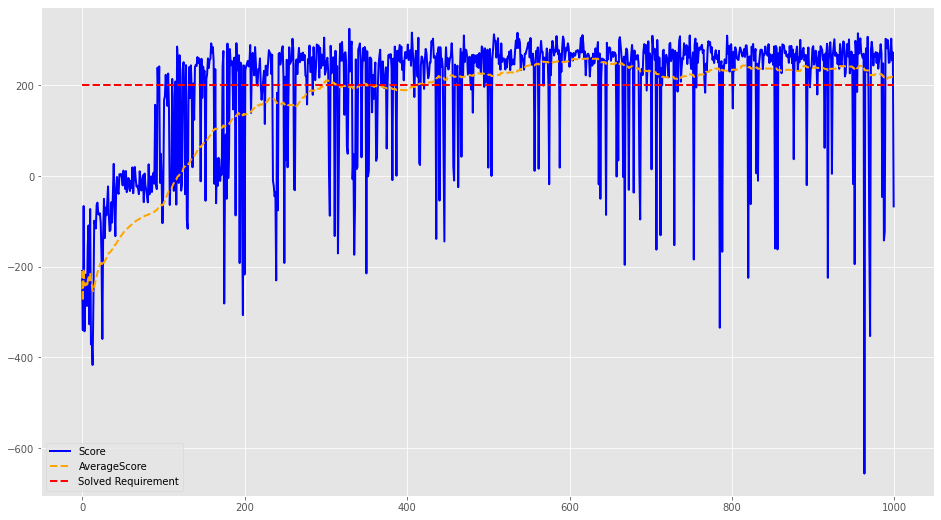

In [7]:
%%time
# Train DDQN Agent
duelingdqn_agent.train_model(env, num_episodes, graph)

In [8]:
# saving weights
! zip -r saved_networks.zip saved_networks

  adding: saved_networks/ (stored 0%)
  adding: saved_networks/duelingdqn_model318/ (stored 0%)
  adding: saved_networks/duelingdqn_model318/net_weights318.h5 (deflated 94%)
  adding: saved_networks/duelingdqn_model318/saved_model.pb (deflated 87%)
  adding: saved_networks/duelingdqn_model318/variables/ (stored 0%)
  adding: saved_networks/duelingdqn_model318/variables/variables.index (deflated 66%)
  adding: saved_networks/duelingdqn_model318/variables/variables.data-00000-of-00001 (deflated 15%)
  adding: saved_networks/duelingdqn_model318/assets/ (stored 0%)
  adding: saved_networks/duelingdqn_model318/keras_metadata.pb (deflated 64%)
  adding: saved_networks/duelingdqn_model205/ (stored 0%)
  adding: saved_networks/duelingdqn_model205/saved_model.pb (deflated 87%)
  adding: saved_networks/duelingdqn_model205/variables/ (stored 0%)
  adding: saved_networks/duelingdqn_model205/variables/variables.index (deflated 66%)
  adding: saved_networks/duelingdqn_model205/variables/variables.da